# Maestría en Inteligencia Artificial Aplicada

## Curso: Operaciones de aprendizaje automático (TC5044.10)

### Fase 1 | Avance de Proyecto

---

**Institution:** Tecnológico de Monterrey

**Instructores:** Dr. Gerardo Rodríguez Hernández, Mtro. Ricardo Valdez Hernández, Mtra. María Mylen Treviño Elizondo & Dr. José Carlos Soto Monterrybio

**Autores (Equipo 34):** 

|  FULL NAME                      |     STUDENT ID    | 
| :--------------------------:    |:-----------------:|
| Emilio Contreras Téllez         |  A01111353        | 
| Claudio Luis Del Valle Azuara   |  A01795773        | 
| Alejandro Díaz Villagómez       |  A01276769        | 
| Guillermo Herrera Acosta        |  A01400835        | 
| Ivan Troy Santaella Martinez    |  A01120515        | 

**Fecha de entrega:** 12 de octubre del 2025

# 1) SETUP AND CONFIGURATION

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import subprocess
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    roc_curve, classification_report
)
from xgboost import XGBClassifier
import joblib

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directory structure
Path('data').mkdir(exist_ok=True)
Path('outputs/figures').mkdir(parents=True, exist_ok=True)
Path('outputs/transformers').mkdir(parents=True, exist_ok=True)

print("✓ Environment setup complete")

✓ Environment setup complete


# 2) DATA ACQUISITION AND INITIAL INSPECTION

In [35]:
# Load dataset
df_raw = pd.read_csv('data/german_credit_modified.csv')

print(f"Shape: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")
print(f"\nData types:\n{df_raw.dtypes.value_counts()}")
print(f"\nFirst 3 rows:")
display(df_raw.head(3))

Shape: 1020 rows × 22 columns

Data types:
object    22
Name: count, dtype: int64

First 3 rows:


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit,mixed_type_col
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,...,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,bad
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,...,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,NaN
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,...,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,unknown


# 3) DATA CLEANING

## 3.1) Column Translation (German → English)

In [36]:
column_mapping = {
    'laufkont': 'checking_account', 'laufzeit': 'duration',
    'moral': 'credit_history', 'verw': 'purpose', 'hoehe': 'amount',
    'sparkont': 'savings_account', 'beszeit': 'employment_duration',
    'rate': 'installment_rate', 'famges': 'personal_status',
    'buerge': 'other_debtors', 'wohnzeit': 'residence_duration',
    'verm': 'property', 'alter': 'age',
    'weitkred': 'other_installment_plans', 'wohn': 'housing',
    'bishkred': 'existing_credits', 'beruf': 'job',
    'pers': 'dependents', 'telef': 'telephone',
    'gastarb': 'foreign_worker', 'kredit': 'credit_risk'
}

df = df_raw.rename(columns=column_mapping)
print("\n[3.1] ✓ Column names translated to English")
print(f"\nFirst 3 rows:")
display(df.head(3))


[3.1] ✓ Column names translated to English

First 3 rows:


,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,personal_status,other_debtors,...,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,credit_risk,mixed_type_col
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,...,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,bad
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,...,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,NaN
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,...,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,unknown


## 3.2) ata Quality Issues - Whitespace Cleaning

In [37]:
print("\n[3.2] Cleaning whitespace from all columns\n")

# Remove problematic column first
if 'mixed_type_col' in df.columns:
    df = df.drop(columns=['mixed_type_col'])
    print("  ✓ Dropped 'mixed_type_col'")

# CRITICAL: Strip whitespace from ALL columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip()

print("  ✓ Whitespace removed from all columns")


[3.2] Cleaning whitespace from all columns

  ✓ Dropped 'mixed_type_col'
  ✓ Whitespace removed from all columns


## 3.3) Type Conversion to Numeric

In [38]:
print("\n[3.3] Converting columns to numeric types\n")

# Convert all columns except target to numeric
numeric_cols = [col for col in df.columns if col != 'credit_risk']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"  ✓ Converted {len(numeric_cols)} columns to numeric")


[3.3] Converting columns to numeric types

  ✓ Converted 20 columns to numeric


## 3.4) Missing Values Analysis and Treatment

In [39]:
print("\n[3.4] Missing Values Analysis and Treatment")

missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values detected:")
    missing_df = pd.DataFrame({
        'Column': missing[missing > 0].index,
        'Missing': missing[missing > 0].values,
        'Percentage': (100 * missing[missing > 0] / len(df)).round(2)
    })
    print(missing_df.to_string(index=False))
    
    print("\nImputation Strategy:")
    
    # Separate target from features
    target_col = 'credit_risk'
    feature_cols = [col for col in df.columns if col != target_col]
    
    # 1. Handle missing target - MUST REMOVE
    rows_removed_target = 0
    if df[target_col].isnull().sum() > 0:
        rows_before = len(df)
        df = df.dropna(subset=[target_col])
        rows_removed_target = rows_before - len(df)
        print(f"  [Target] Removed {rows_removed_target} rows with missing target")
    
    # 2. Define variable types for appropriate imputation
    # Continuous variables → median imputation
    continuous_vars = ['duration', 'amount', 'installment_rate', 'age', 
                      'residence_duration', 'existing_credits']
    
    # Discrete/categorical (even if numeric) → mode imputation  
    discrete_vars = [col for col in feature_cols if col not in continuous_vars]
    
    # 3. Impute continuous with median
    total_imputed = 0
    for col in continuous_vars:
        if col in df.columns and df[col].isnull().sum() > 0:
            median_val = df[col].median()
            n_imputed = df[col].isnull().sum()
            df[col] = df[col].fillna(median_val)
            total_imputed += n_imputed
            print(f"  [{col}] Imputed {n_imputed} values with median ({median_val:.2f})")
    
    # 4. Impute discrete with mode
    for col in discrete_vars:
        if col in df.columns and df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 0
            n_imputed = df[col].isnull().sum()
            df[col] = df[col].fillna(mode_val)
            total_imputed += n_imputed
            print(f"  [{col}] Imputed {n_imputed} values with mode ({mode_val})")
    
    # 5. Verify no missing values remain
    remaining_missing = df.isnull().sum().sum()
    if remaining_missing == 0:
        print(f"\n✓ All missing values handled successfully")
        print(f"  Rows removed (missing target): {rows_removed_target}")
        print(f"  Values imputed (features): {total_imputed}")
        print(f"  Final dataset: {len(df)} rows ({100*len(df)/len(df_raw):.1f}% of original)")
    else:
        print(f"\n⚠ Warning: {remaining_missing} missing values remain")
        rows_before = len(df)
        df = df.dropna()
        print(f"  Dropped {rows_before - len(df)} remaining rows with NaNs")
        
else:
    print("✓ No missing values detected")


[3.4] Missing Values Analysis and Treatment

Missing values detected:
                 Column  Missing  Percentage
       checking_account       19        1.86
               duration       11        1.08
         credit_history       18        1.76
                purpose       22        2.16
                 amount       12        1.18
        savings_account       15        1.47
    employment_duration       19        1.86
       installment_rate       12        1.18
        personal_status       11        1.08
          other_debtors       16        1.57
     residence_duration       17        1.67
               property       15        1.47
                    age       12        1.18
other_installment_plans       14        1.37
                housing        9        0.88
       existing_credits       20        1.96
                    job       15        1.47
             dependents       10        0.98
              telephone       16        1.57
         foreign_worker      

## 3.5b) Categorical Variable Validation and Cleaning

In [40]:
print("\n[3.5b] Categorical Variable Validation")

# Define expected valid ranges for categorical variables
categorical_ranges = {
    'checking_account': [1.0, 2.0, 3.0, 4.0],
    'credit_history': [0.0, 1.0, 2.0, 3.0, 4.0],
    'purpose': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0],
    'savings_account': [1.0, 2.0, 3.0, 4.0, 5.0],
    'employment_duration': [1.0, 2.0, 3.0, 4.0, 5.0],
    'personal_status': [1.0, 2.0, 3.0, 4.0],
    'other_debtors': [1.0, 2.0, 3.0],
    'property': [1.0, 2.0, 3.0, 4.0],
    'other_installment_plans': [1.0, 2.0, 3.0],
    'housing': [1.0, 2.0, 3.0],
    'job': [1.0, 2.0, 3.0, 4.0],
    'dependents': [1.0, 2.0],
    'telephone': [1.0, 2.0],
    'foreign_worker': [1.0, 2.0]
}

print("\nValidating categorical variables...")
total_invalid = 0
rows_before = len(df)

for col, valid_values in categorical_ranges.items():
    if col in df.columns:
        # Find invalid values
        invalid_mask = ~df[col].isin(valid_values)
        n_invalid = invalid_mask.sum()
        
        if n_invalid > 0:
            print(f"  [{col}] Found {n_invalid} invalid values: {df[col][invalid_mask].unique()}")
            # Remove rows with invalid categorical values
            df = df[~invalid_mask]
            total_invalid += n_invalid

if total_invalid > 0:
    print(f"\n→ Removed {rows_before - len(df)} rows with invalid categorical values")
    print(f"  Remaining: {len(df)} rows")
else:
    print("✓ All categorical variables have valid values")


[3.5b] Categorical Variable Validation

Validating categorical variables...
  [checking_account] Found 13 invalid values: [518. 916. 360. 497.  64. 444.  96.  76.  92. 685. 144. 104. 667.]
  [credit_history] Found 18 invalid values: [172. 907. 100. 166.  60. 112. 531. 216. 260. 894.  70. 601. 477. 645.
 389.  40. 709. 446.]
  [purpose] Found 8 invalid values: [263. 488. 456. 147. 655. 120.  92.  46.]
  [savings_account] Found 8 invalid values: [ 272. 1000.  398.  235.  672.  610.  992.  240.]
  [employment_duration] Found 7 invalid values: [179.  90. 267. 195. 141.  45.  63.]
  [personal_status] Found 5 invalid values: [241. 322. 110.  86. 724.]
  [other_debtors] Found 12 invalid values: [542.  62. 155.  10. 416. 610. 973.  14. 330.  33.  46.  98.]
  [property] Found 8 invalid values: [829. 216. 340. 186.  30. 144. 297.  76.]
  [other_installment_plans] Found 8 invalid values: [847. 966. 372. 203. 568. 141. 348. 931.]
  [housing] Found 9 invalid values: [176. 516. 630. 158.  90. 312. 

## 3.5) Target Variable Cleaning

In [41]:
print("\n[3.5] Target variable 'credit_risk' cleaning")

# Target is still object type, clean it separately
df['credit_risk'] = df['credit_risk'].astype(str).str.strip()

# Keep ONLY '1.0' and '0.0' (or '1' and '0')
valid_values = ['1.0', '0.0', '1', '0']
rows_before = len(df)
df = df[df['credit_risk'].isin(valid_values)].copy()
rows_removed = rows_before - len(df)

# Standardize to '1' and '0'
df['credit_risk'] = df['credit_risk'].str.replace('.0', '', regex=False)

print(f"\n  → Removed {rows_removed} rows with invalid target")
print(f"\n  → Final values: {sorted(df['credit_risk'].unique())}")
print(f"\n  → Distribution:\n{df['credit_risk'].value_counts()}")


[3.5] Target variable 'credit_risk' cleaning

  → Removed 24 rows with invalid target

  → Final values: ['0', '1']

  → Distribution:
credit_risk
1    595
0    260
Name: count, dtype: int64


## 3.6) Remove Duplicates

In [42]:
print("[3.6] Duplicate Detection\n")

duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"  ✓ Removed {duplicates} duplicate rows")
else:
    print(f"  ✓ No duplicates found")

[3.6] Duplicate Detection

  ✓ Removed 9 duplicate rows


## 3.7) Outlier Detection and Treatment

In [43]:
print("\n[3.7] Outlier Detection and Treatment")

# Analyze outliers using IQR method on key numeric features
continuous_features = ['duration', 'amount', 'installment_rate', 'age', 
                   'residence_duration', 'existing_credits']

print("\nOutlier analysis (IQR method, 3x multiplier):")

outlier_summary = []
for col in continuous_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    n_lower = (df[col] < lower_bound).sum()
    n_upper = (df[col] > upper_bound).sum()
    total_outliers = n_lower + n_upper
    pct_outliers = 100 * total_outliers / len(df)
    
    outlier_summary.append({
        'Feature': col,
        'Lower_outliers': n_lower,
        'Upper_outliers': n_upper,
        'Total_outliers': total_outliers,
        'Percentage': f'{pct_outliers:.1f}%',
        'Q1': f'{Q1:.1f}',
        'Q3': f'{Q3:.1f}',
        'IQR': f'{IQR:.1f}'
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df[['Feature', 'Total_outliers', 'Percentage']].to_string(index=False))

# Treatment strategy: Cap extreme outliers
print("\nOutlier treatment strategy:")
print("  Method: IQR with 3x multiplier (conservative)")
print("  Action: Cap values at boundaries (winsorization)")
print("  Rationale: Preserve information while reducing extreme influence\n")

rows_before = len(df)
for col in continuous_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count how many will be capped
    n_lower_capped = (df[col] < lower_bound).sum()
    n_upper_capped = (df[col] > upper_bound).sum()
    
    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    if (n_lower_capped + n_upper_capped) > 0:
        print(f"  [{col}] Capped {n_lower_capped + n_upper_capped} values "
              f"({n_lower_capped} lower, {n_upper_capped} upper)")

print(f"\n✓ Outlier treatment complete")
print(f"  Rows retained: {len(df)} (no rows removed, only capped)")
print(f"  Note: Using 3x IQR multiplier preserves ~99.7% of normal distribution")



[3.7] Outlier Detection and Treatment

Outlier analysis (IQR method, 3x multiplier):
           Feature  Total_outliers Percentage
          duration               7       0.8%
            amount              24       2.8%
  installment_rate               3       0.4%
               age               6       0.7%
residence_duration               8       0.9%
  existing_credits              13       1.5%

Outlier treatment strategy:
  Method: IQR with 3x multiplier (conservative)
  Action: Cap values at boundaries (winsorization)
  Rationale: Preserve information while reducing extreme influence

  [duration] Capped 7 values (0 lower, 7 upper)
  [amount] Capped 24 values (0 lower, 24 upper)
  [installment_rate] Capped 3 values (0 lower, 3 upper)
  [age] Capped 6 values (0 lower, 6 upper)
  [residence_duration] Capped 8 values (0 lower, 8 upper)
  [existing_credits] Capped 13 values (0 lower, 13 upper)

✓ Outlier treatment complete
  Rows retained: 846 (no rows removed, only capped)
  N

## 3.8) Cleaning Summary

In [44]:
print("[3.8] Cleaning Summary\n")
print(f"Original shape:  {df_raw.shape}")
print(f"Cleaned shape:   {df.shape}")
print(f"Rows removed:    {df_raw.shape[0] - df.shape[0]} ({100*(df_raw.shape[0]-df.shape[0])/df_raw.shape[0]:.1f}%)")
print(f"\nFinal target distribution:")
print(df['credit_risk'].value_counts())
print(f"\nData quality checks:")
print(f"  Missing values: {df.isnull().sum().sum()}")
print(f"  Duplicates: {df.duplicated().sum()}")
print(f"  Numeric columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"  Object columns: {df.select_dtypes(include=['object']).shape[1]} (target only)")

[3.8] Cleaning Summary

Original shape:  (1020, 22)
Cleaned shape:   (846, 21)
Rows removed:    174 (17.1%)

Final target distribution:
credit_risk
1    590
0    256
Name: count, dtype: int64

Data quality checks:
  Missing values: 0
  Duplicates: 0
  Numeric columns: 20
  Object columns: 1 (target only)


# 4) DATA VERSIONING v1 - CLEANED DATA

In [45]:
# Save cleaned dataset
cleaned_path = 'data/german_credit_cleaned_v1.csv'
df.to_csv(cleaned_path, index=False)
print(f"✓ Cleaned dataset saved: {cleaned_path}")

# Initialize DVC (if not already initialized)
try:
    subprocess.run(['dvc', 'version'], capture_output=True, check=True)
    print("✓ DVC is installed")
    
    # Add file to DVC
    try:
        subprocess.run(['dvc', 'add', cleaned_path], capture_output=True, check=True)
        print(f"✓ DVC tracking enabled for {cleaned_path}")
        print("  → Run: git add data/german_credit_cleaned_v1.csv.dvc data/.gitignore")
        print("  → Run: git commit -m 'v1: cleaned dataset'")
    except subprocess.CalledProcessError:
        print("⚠ DVC add failed (may already be tracked)")
except FileNotFoundError:
    print("⚠ DVC not installed. Install with: pip install dvc")
    print("  For now, data is saved locally without versioning.")

✓ Cleaned dataset saved: data/german_credit_cleaned_v1.csv
✓ DVC is installed
⚠ DVC add failed (may already be tracked)


# 5) EXPLORATORY DATA ANALYSIS (EDA)

## 5.1) Univariate Analysis


[5.1] Univariate Analysis - All Features

Continuous/Count Features: 6
Categorical Features (encoded): 14

--- Continuous Features Statistics ---


,duration,amount,installment_rate,age,residence_duration,existing_credits
count,846.00,846.00,846.00,846.00,846.00,846.00
mean,20.95,3224.59,2.99,35.62,2.89,1.46
std,12.30,2618.13,1.19,12.11,1.29,0.72
min,4.00,250.00,1.00,19.00,1.00,1.00
25%,12.00,1386.50,2.00,27.00,2.00,1.00
50%,18.00,2319.50,3.00,33.00,3.00,1.00
75%,24.00,3972.75,4.00,41.75,4.00,2.00
max,60.00,11731.50,10.00,86.00,10.00,5.00


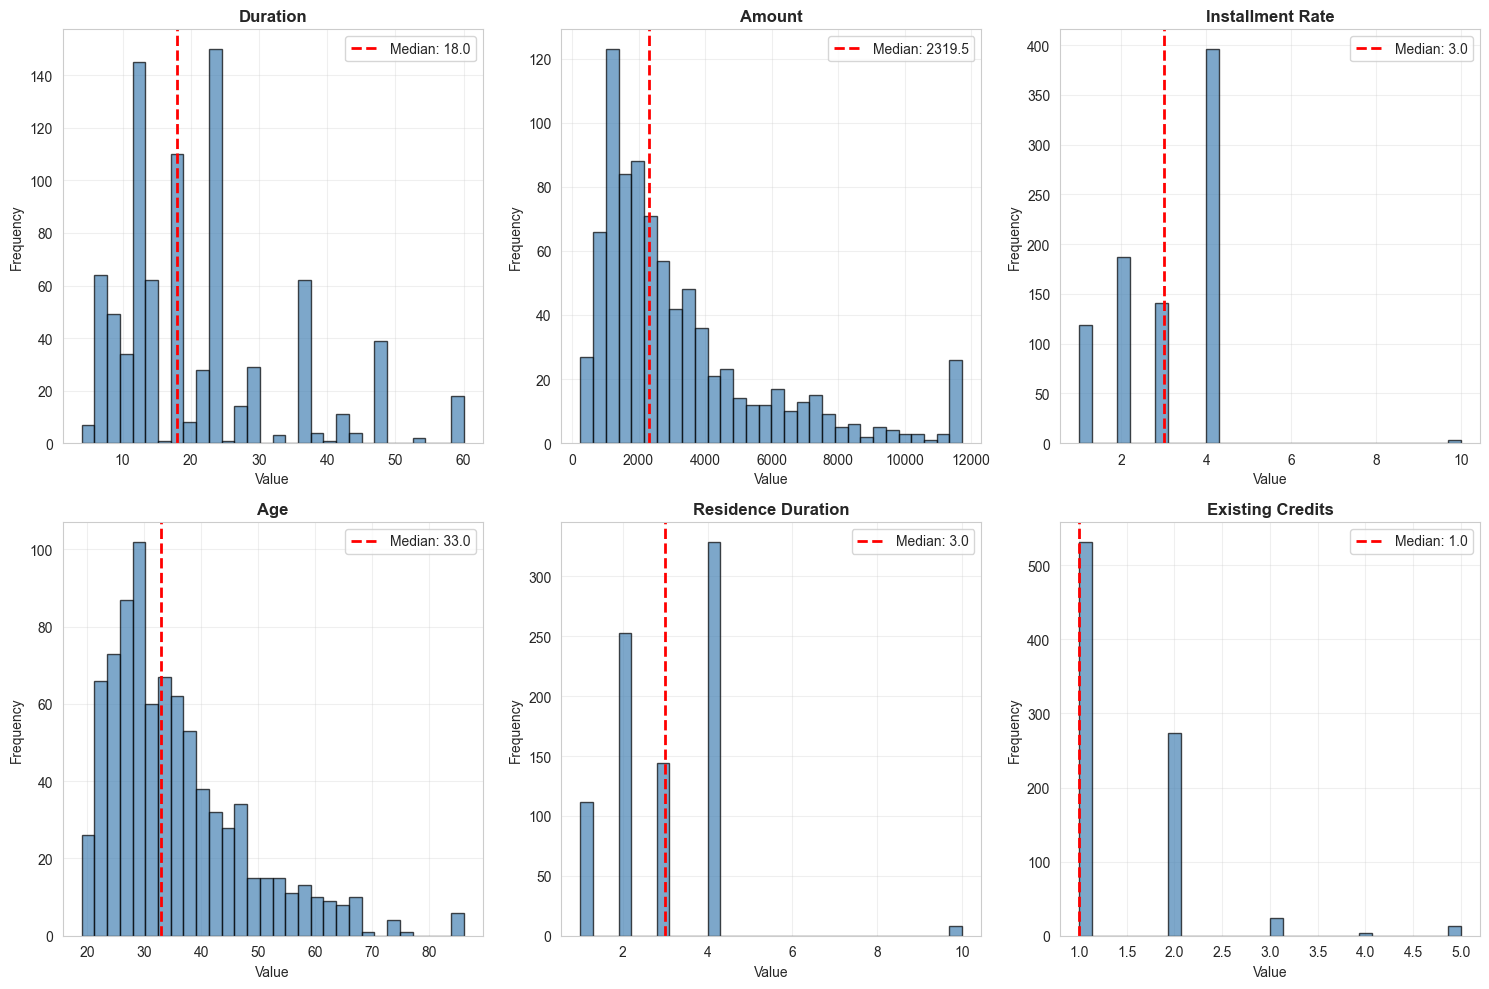


--- Categorical Features (Encoded as Numeric) ---


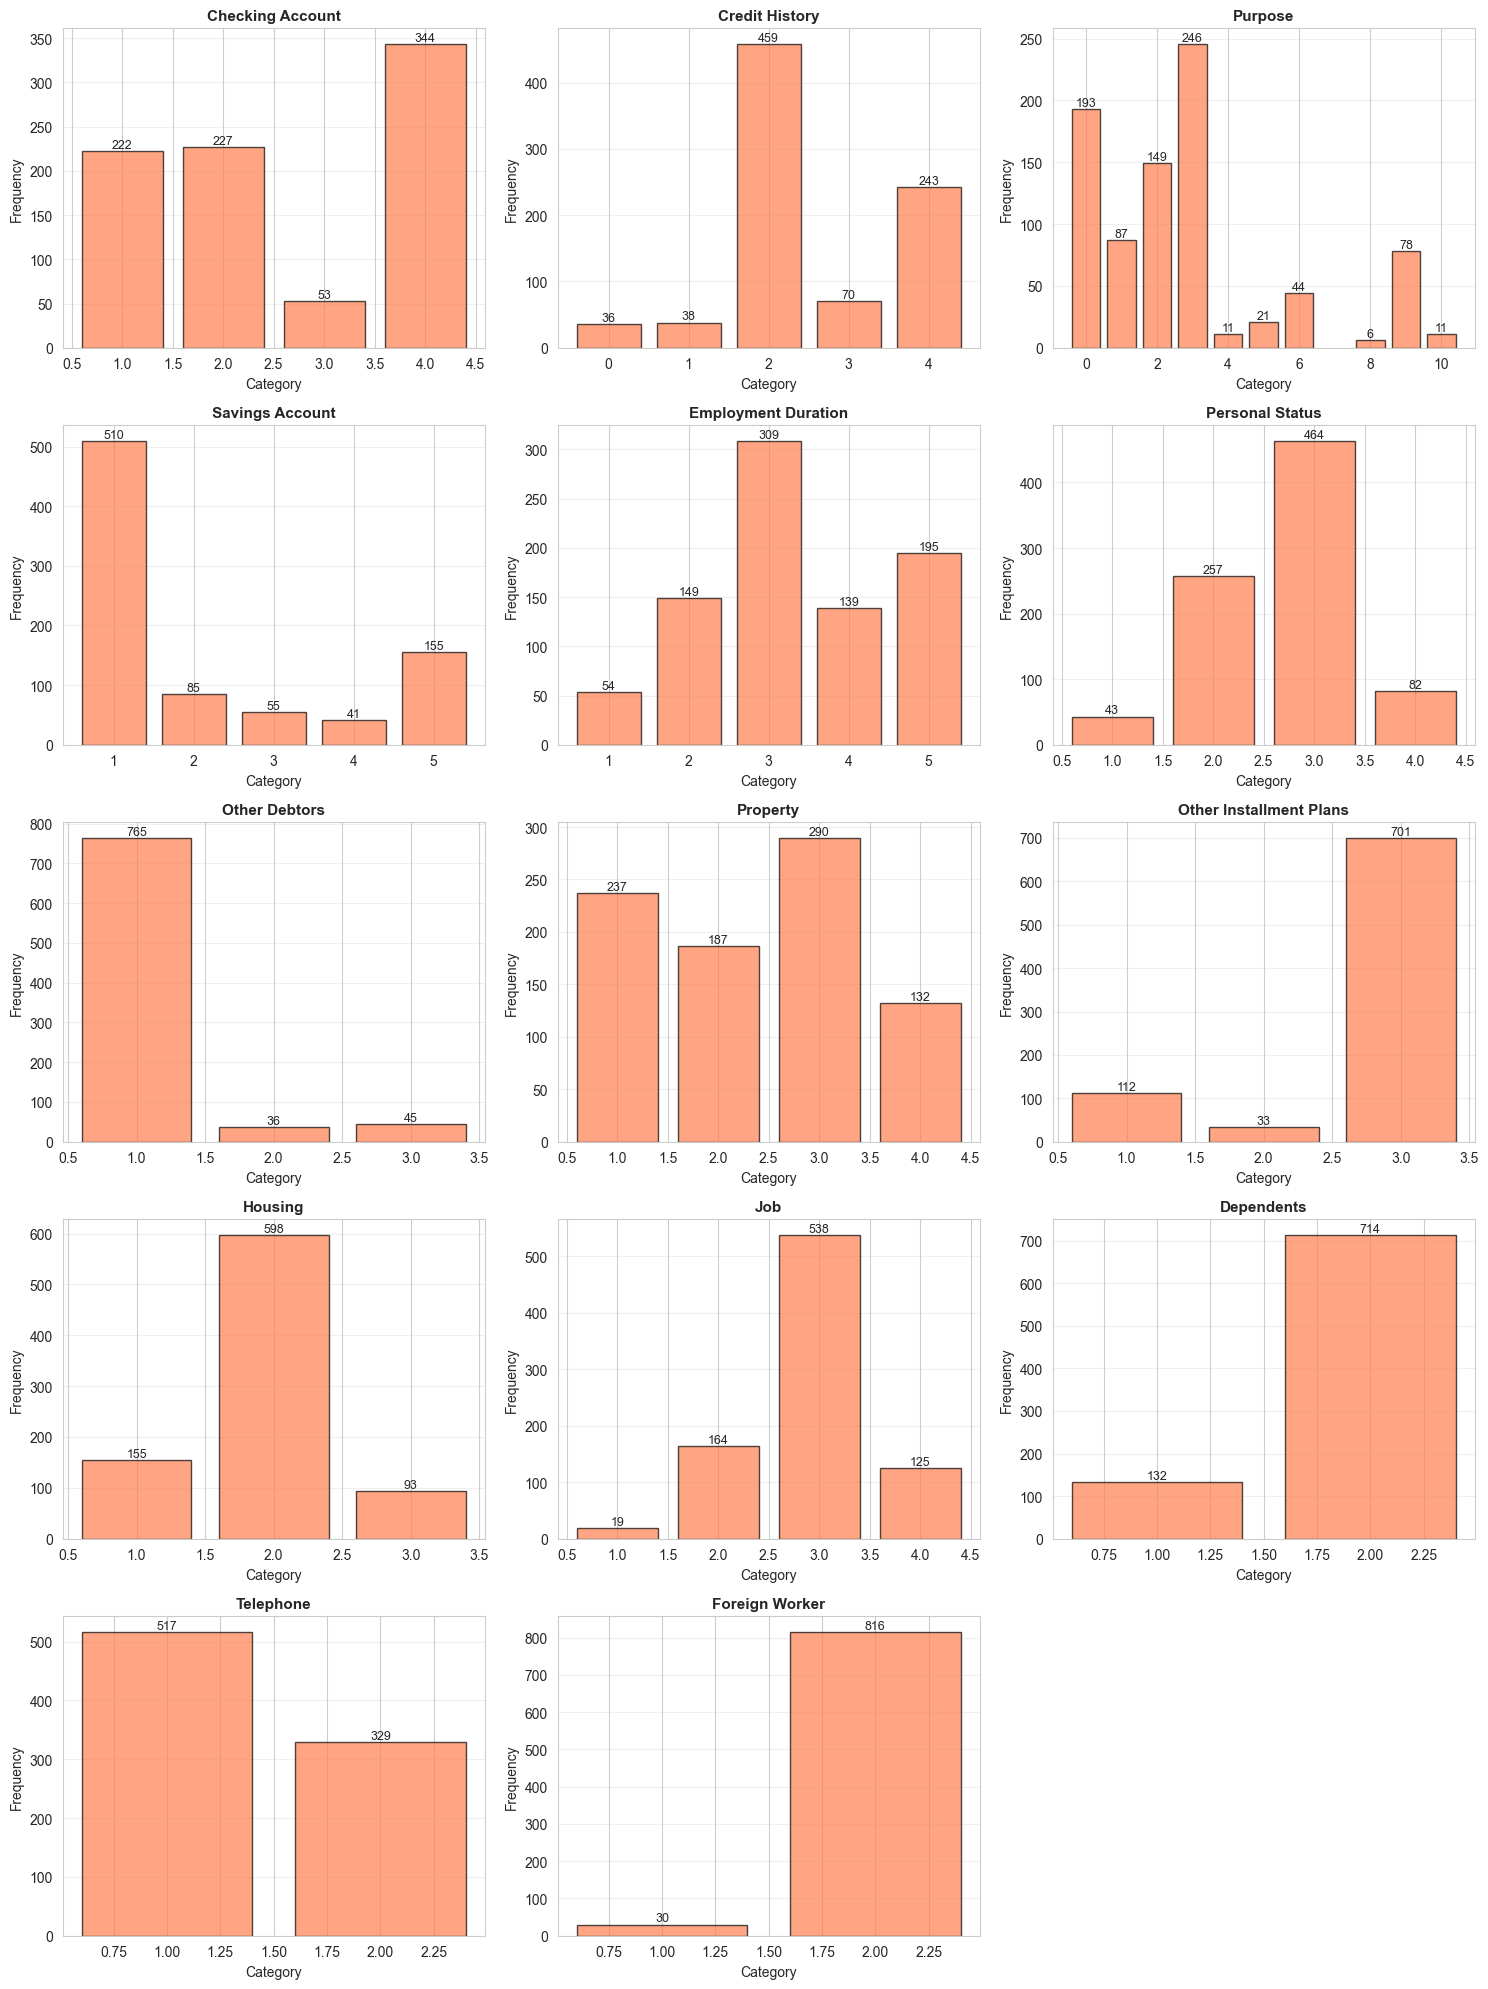


✓ Univariate analysis complete for all features


In [46]:
print("\n[5.1] Univariate Analysis - All Features")

# Separate feature types for better visualization
categorical_features = [col for col in df.select_dtypes(include=[np.number]).columns 
                       if col not in continuous_features and col != 'credit_risk']

print(f"\nContinuous/Count Features: {len(continuous_features)}")
print(f"Categorical Features (encoded): {len(categorical_features)}")

# --- Part A: Continuous Features ---
print("\n--- Continuous Features Statistics ---")
display(df[continuous_features].describe().round(2))

# Visualize continuous distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(continuous_features):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{col.replace("_", " ").title()}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(df[col].median(), color='red', linestyle='--', linewidth=2,
                     label=f'Median: {df[col].median():.1f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/01_univariate_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Part B: Categorical Features ---
print("\n--- Categorical Features (Encoded as Numeric) ---")

# Visualize categorical distributions (bar charts)
n_categorical = len(categorical_features)
n_rows = (n_categorical + 2) // 3  # Ceiling division
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    value_counts = df[col].value_counts().sort_index()
    axes[idx].bar(value_counts.index, value_counts.values, 
                 edgecolor='black', alpha=0.7, color='coral')
    axes[idx].set_title(f'{col.replace("_", " ").title()}', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Category')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(value_counts.values):
        axes[idx].text(value_counts.index[i], v + max(value_counts.values)*0.01, 
                      str(v), ha='center', fontsize=9)

# Remove empty subplots
for idx in range(n_categorical, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('outputs/figures/01_univariate_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Univariate analysis complete for all features")

## 5.2) Target Distribution


[5.2] Target Distribution Analysis

Credit Risk Distribution:
  1: 590 (69.7%)
  0: 256 (30.3%)


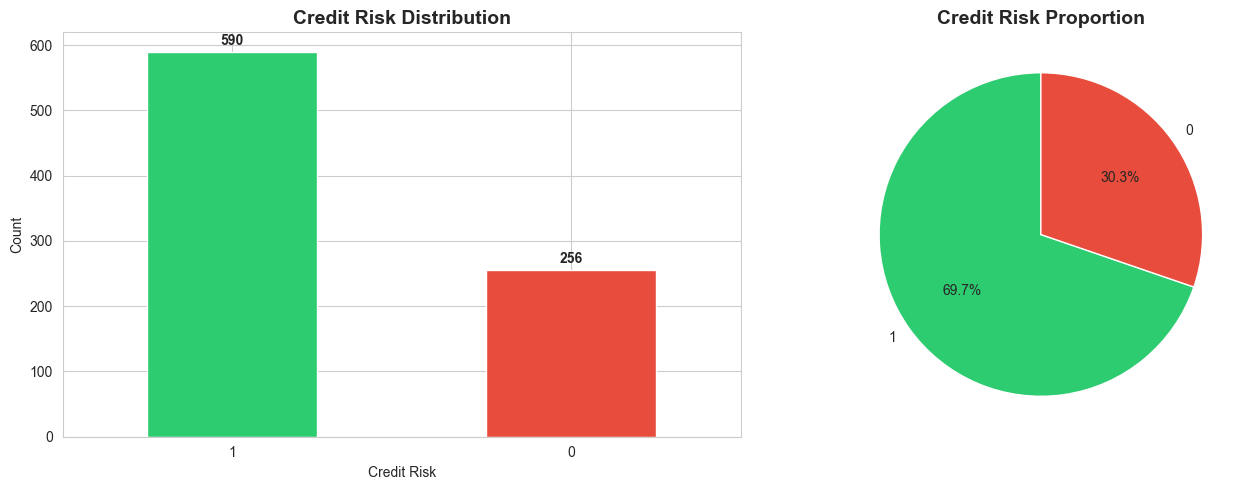

In [47]:
print("\n[5.2] Target Distribution Analysis")

target_counts = df['credit_risk'].value_counts()
target_pct = df['credit_risk'].value_counts(normalize=True) * 100

print(f"\nCredit Risk Distribution:")
for value, count in target_counts.items():
    print(f"  {value}: {count} ({target_pct[value]:.1f}%)")

# Visualize target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
target_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Credit Risk Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Credit Risk')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate(target_counts):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%',
           colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Credit Risk Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/02_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5.3) Bivariate Analysis - Numerical vs Target


[5.3] Bivariate Analysis - Numerical Features vs Target


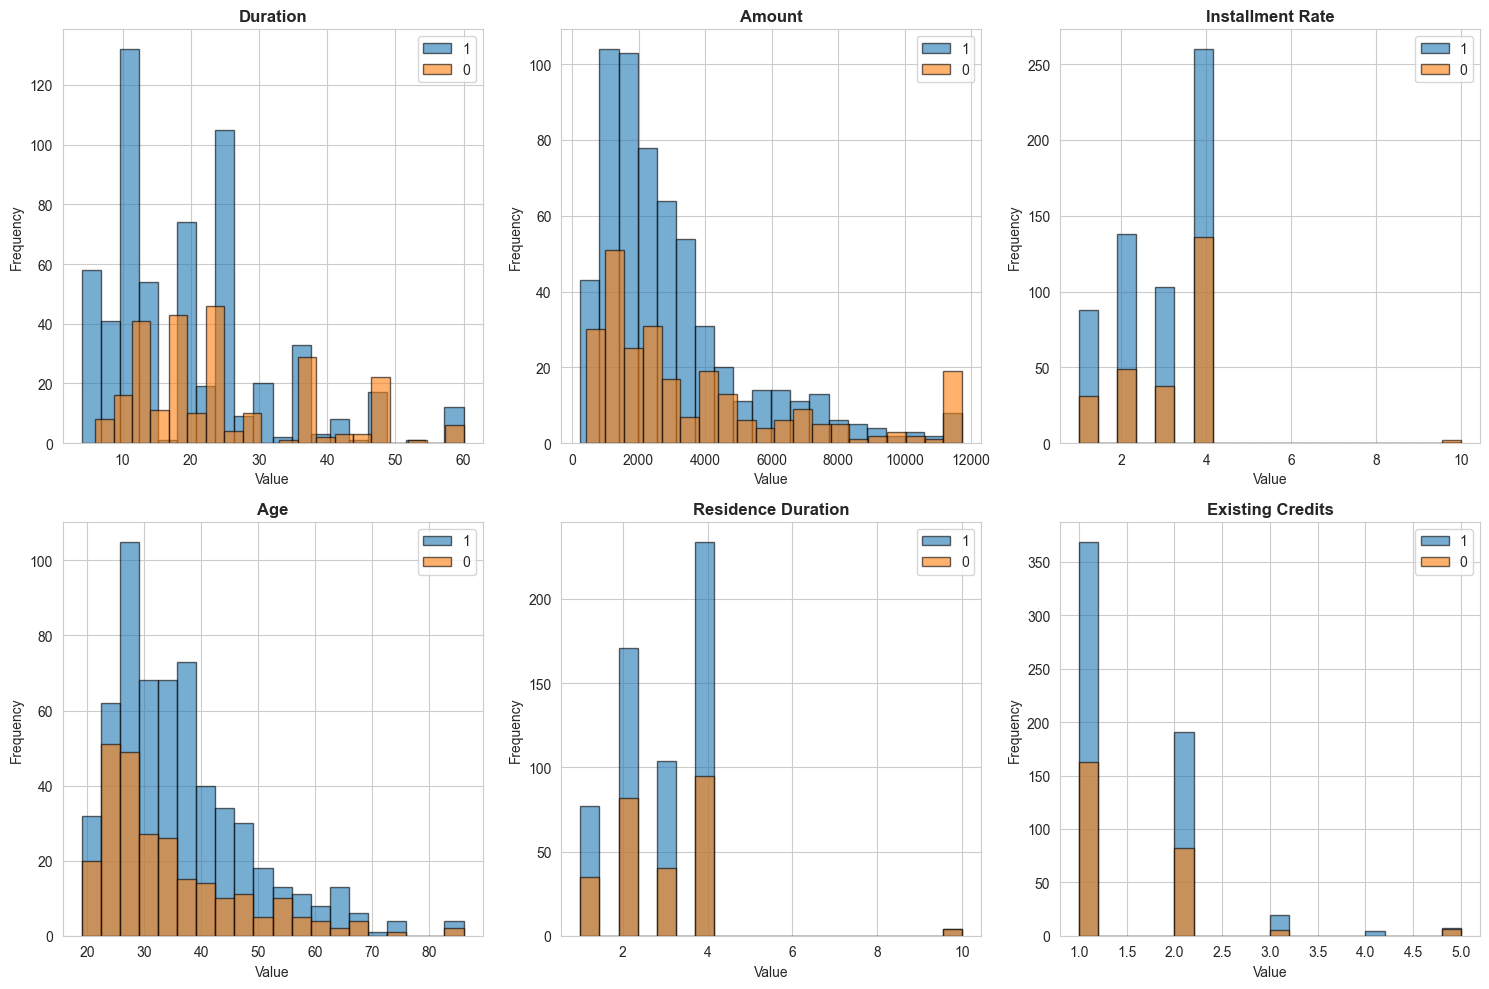


Mean values by credit risk:


,duration,amount,installment_rate,age,residence_duration,existing_credits
credit_risk,,,,,,
0,24.34,3777.31,3.15,34.18,2.89,1.45
1,19.48,2984.77,2.92,36.25,2.89,1.46


In [48]:
print("\n[5.3] Bivariate Analysis - Numerical Features vs Target")

# Compare distributions by target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(continuous_features):
    for risk in df['credit_risk'].unique():
        data = df[df['credit_risk'] == risk][col]
        axes[idx].hist(data, bins=20, alpha=0.6, label=risk, edgecolor='black')
    
    axes[idx].set_title(f'{col.replace("_", " ").title()}', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('outputs/figures/03_bivariate_numerical.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
print("\nMean values by credit risk:")
comparison = df.groupby('credit_risk')[continuous_features].mean().round(2)
display(comparison)

## 5.4) Multivariate Analysis - Correlation Matrix


[5.4] Correlation Analysis


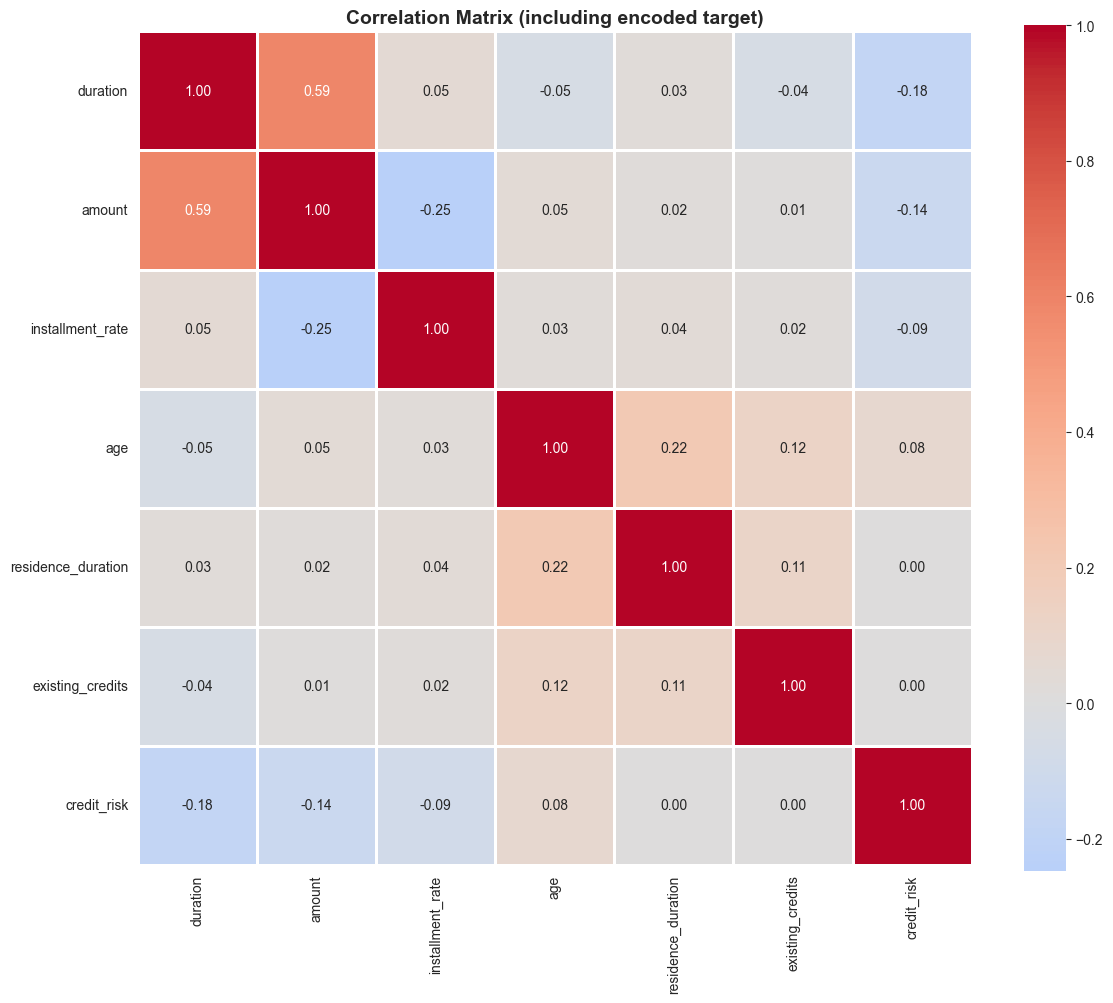


Top 5 features correlated with credit_risk:
duration              0.181810
amount                0.139144
installment_rate      0.089268
age                   0.078563
residence_duration    0.002312
Name: credit_risk, dtype: float64


In [49]:
print("\n[5.4] Correlation Analysis")

df_corr = df.copy()

# Asure target is numeric
df_corr['credit_risk'] = pd.to_numeric(df_corr['credit_risk'], errors='coerce').astype(int)

corr_features = continuous_features + ['credit_risk']
corr_matrix = df_corr[corr_features].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           center=0, square=True, linewidths=1)
plt.title('Correlation Matrix (including encoded target)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/figures/04_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 features correlated with credit_risk:")
target_corr = corr_matrix['credit_risk'].drop('credit_risk').abs().sort_values(ascending=False)
print(target_corr.head())

In [50]:
df['credit_risk'].value_counts()


credit_risk
1    590
0    256
Name: count, dtype: int64

## 5.5) Outlier Visualization (Post-Treatment)


[5.5] Outlier Visualization (Post-Treatment)


,Feature,Outliers,Percentage,Lower_Bound,Upper_Bound
0,duration,63,7.4%,-6.0,42.0
1,amount,60,7.1%,-2492.9,7852.1
2,installment_rate,3,0.4%,-1.0,7.0
3,age,30,3.5%,4.9,63.9
4,residence_duration,8,0.9%,-1.0,7.0
5,existing_credits,17,2.0%,-0.5,3.5


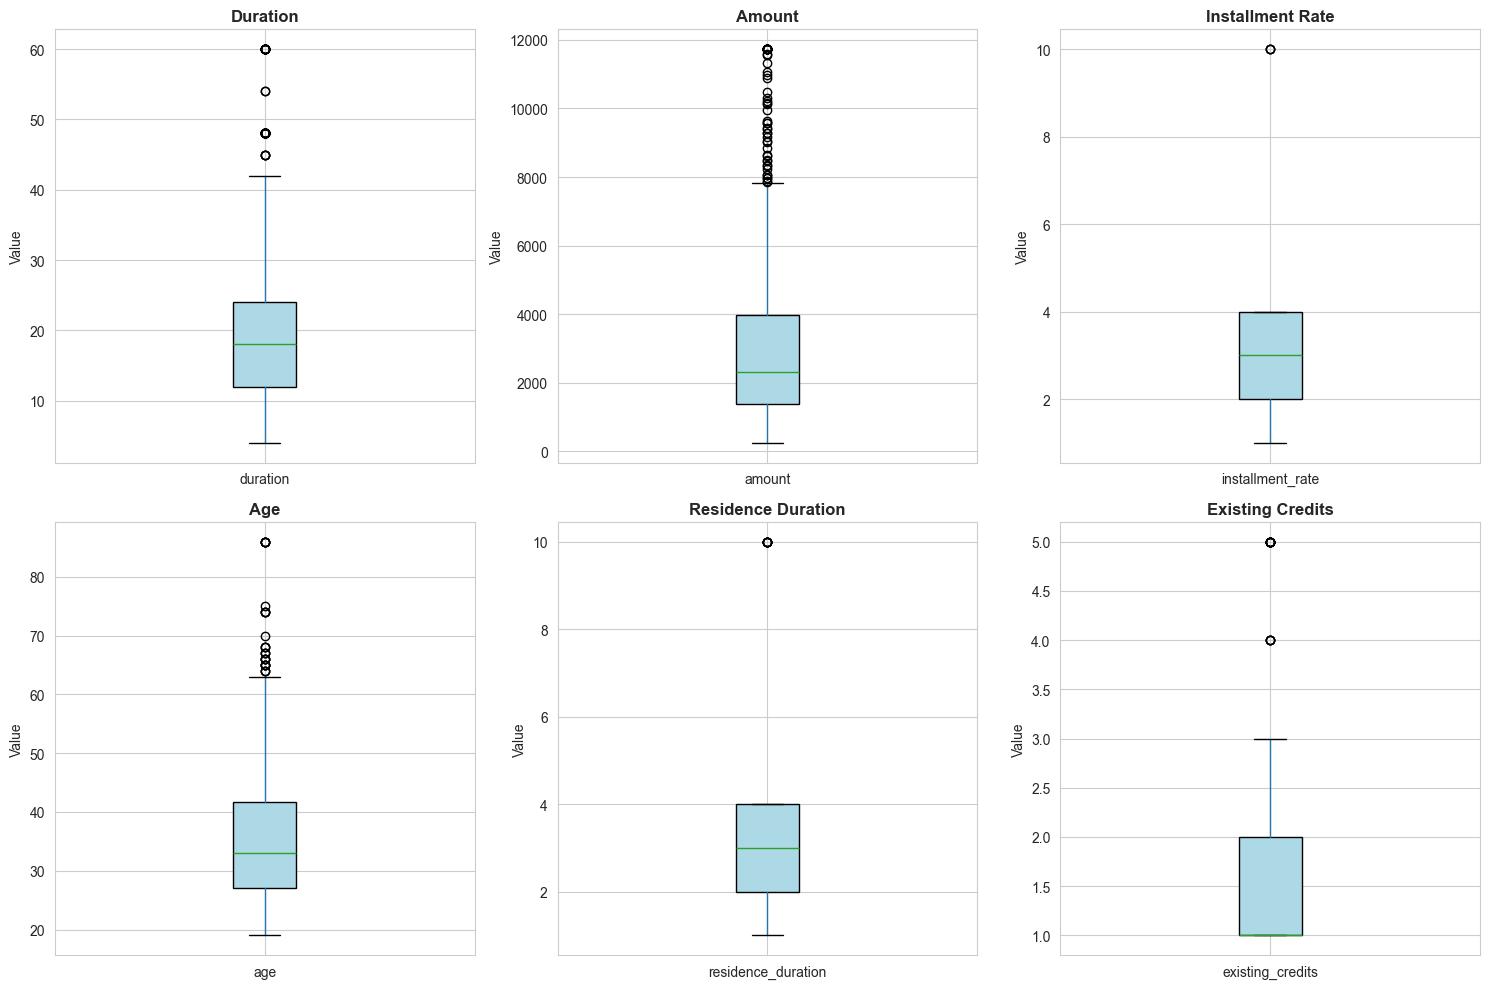

In [51]:
print("\n[5.5] Outlier Visualization (Post-Treatment)")

outlier_summary = []
for col in continuous_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_pct = 100 * outliers / len(df)
    
    outlier_summary.append({
        'Feature': col,
        'Outliers': outliers,
        'Percentage': f"{outlier_pct:.1f}%",
        'Lower_Bound': f"{lower:.1f}",
        'Upper_Bound': f"{upper:.1f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

# Visualize with boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(continuous_features):
    df.boxplot(column=col, ax=axes[idx], patch_artist=True,
              boxprops=dict(facecolor='lightblue'))
    axes[idx].set_title(f'{col.replace("_", " ").title()}', fontweight='bold')
    axes[idx].set_ylabel('Value')

plt.tight_layout()
plt.savefig('outputs/figures/05_outlier_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## 6) DATA PREPROCESSING

In [52]:
# Create copy for preprocessing
df_processed = df.copy()

## 6.1) Categorical Encoding

In [53]:
print("\n[6.1] Categorical Encoding")

# Separate features and target
X = df_processed.drop('credit_risk', axis=1)
y = df_processed['credit_risk']

# All features are currently numeric (already encoded in original data)
# But we encode target to binary
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # good=1, bad=0 (or vice versa)
print(f"\n  Target encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Save label encoder
import pickle
with open('outputs/transformers/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("  ✓ Label encoder saved")


[6.1] Categorical Encoding

  Target encoded: {'0': np.int64(0), '1': np.int64(1)}
  ✓ Label encoder saved


## 6.2) Numerical Scaling

In [54]:
print("\n[6.2] Numerical Scaling (StandardScaler)")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n  ✓ Scaled {X.shape[1]} features")
print(f"  Sample means after scaling: {X_scaled.mean().round(3).head().to_dict()}")
print(f"  Sample stds after scaling:  {X_scaled.std().round(3).head().to_dict()}")

# Save scaler
with open('outputs/transformers/standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("  ✓ Scaler saved")


[6.2] Numerical Scaling (StandardScaler)

  ✓ Scaled 20 features
  Sample means after scaling: {'checking_account': -0.0, 'duration': 0.0, 'credit_history': -0.0, 'purpose': 0.0, 'amount': 0.0}
  Sample stds after scaling:  {'checking_account': 1.001, 'duration': 1.001, 'credit_history': 1.001, 'purpose': 1.001, 'amount': 1.001}
  ✓ Scaler saved


## 6.3) Feature Engineering

In [55]:
print("\n[6.3] Feature Engineering")

# Create new features
X_scaled['amount_per_month'] = df_processed['amount'] / df_processed['duration']
X_scaled['age_at_end'] = df_processed['age'] + (df_processed['duration'] / 12)
X_scaled['debt_burden'] = df_processed['installment_rate'] * df_processed['duration']

engineered_features = ['amount_per_month', 'age_at_end', 'debt_burden']
print(f"\n  Created {len(engineered_features)} new features:")
for feat in engineered_features:
    print(f"    - {feat}")

# Scale new features
scaler_new = StandardScaler()
X_scaled[engineered_features] = scaler_new.fit_transform(X_scaled[engineered_features])



[6.3] Feature Engineering

  Created 3 new features:
    - amount_per_month
    - age_at_end
    - debt_burden


## 6.4) Train/Test Split

In [56]:
pd.Series(y_encoded).value_counts()

1    590
0    256
Name: count, dtype: int64

In [57]:
print("\n[6.4] Train/Test Split")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n  Training set:   {X_train.shape[0]} samples ({100*len(X_train)/len(X_scaled):.0f}%)")
print(f"  Test set:       {X_test.shape[0]} samples ({100*len(X_test)/len(X_scaled):.0f}%)")
print(f"  Features:       {X_train.shape[1]}")
print(f"\n  Target distribution in train:")
print(f"    Class 0: {(y_train == 0).sum()} ({100*(y_train == 0).sum()/len(y_train):.1f}%)")
print(f"    Class 1: {(y_train == 1).sum()} ({100*(y_train == 1).sum()/len(y_train):.1f}%)")

# Save splits
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
pd.Series(y_train).to_csv('data/y_train.csv', index=False, header=['credit_risk'])
pd.Series(y_test).to_csv('data/y_test.csv', index=False, header=['credit_risk'])
print("\n  ✓ Train/test splits saved to data/")


[6.4] Train/Test Split

  Training set:   676 samples (80%)
  Test set:       170 samples (20%)
  Features:       23

  Target distribution in train:
    Class 0: 205 (30.3%)
    Class 1: 471 (69.7%)

  ✓ Train/test splits saved to data/


# 7) DATA VERSIONING v2 - PROCESSED DATA

In [58]:
# Save fully processed dataset
processed_df = X_scaled.copy()
processed_df['credit_risk'] = y_encoded
processed_path = 'data/german_credit_processed_v2.csv'
processed_df.to_csv(processed_path, index=False)
print(f"✓ Processed dataset saved: {processed_path}")

# Add to DVC
try:
    subprocess.run(['dvc', 'add', processed_path], capture_output=True, check=True)
    print(f"✓ DVC tracking enabled for {processed_path}")
    print("  → Run: git add data/german_credit_processed_v2.csv.dvc")
    print("  → Run: git commit -m 'v2: preprocessed dataset ready for modeling'")
except:
    print("⚠ DVC add skipped (not installed or already tracked)")

✓ Processed dataset saved: data/german_credit_processed_v2.csv
⚠ DVC add skipped (not installed or already tracked)


# 8) MODEL TRAINING AND EVALUATION

## 8.1) Load Preprocessed Data

In [59]:
print("\n[8.1] Loading Preprocessed Data")

# Verify data files exist
from pathlib import Path

data_files = {
    'X_train': 'data/X_train.csv',
    'X_test': 'data/X_test.csv',
    'y_train': 'data/y_train.csv',
    'y_test': 'data/y_test.csv'
}

print("\nVerifying data files...")
for name, path in data_files.items():
    exists = Path(path).exists()
    status = "✓" if exists else "✗"
    print(f"  {status} {path}")

# Load data
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

print(f"\n✓ Data loaded successfully")
print(f"  Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Test set:     {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"\n  Target distribution (train):")
print(f"    Class 0: {(y_train == 0).sum()} ({100*(y_train == 0).sum()/len(y_train):.1f}%)")
print(f"    Class 1: {(y_train == 1).sum()} ({100*(y_train == 1).sum()/len(y_train):.1f}%)")


[8.1] Loading Preprocessed Data

Verifying data files...
  ✓ data/X_train.csv
  ✓ data/X_test.csv
  ✓ data/y_train.csv
  ✓ data/y_test.csv

✓ Data loaded successfully
  Training set: 676 samples, 23 features
  Test set:     170 samples, 23 features

  Target distribution (train):
    Class 0: 205 (30.3%)
    Class 1: 471 (69.7%)


# 8.2) Model Selection and Training

In [60]:
print("\n[8.2] Model Selection and Training")

# Define models with reasonable hyperparameters
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight='balanced'  # Handle class imbalance
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        random_state=42,
        class_weight='balanced'
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()  # Handle class imbalance
    )
}


[8.2] Model Selection and Training


In [61]:
# Train all models
fitted_models = {}
training_results = []

for name, model in models.items():
    print(f"\n  Training: {name}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Get probability scores for ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_score_train = model.predict_proba(X_train)[:, 1]
        y_score_test = model.predict_proba(X_test)[:, 1]
    else:
        y_score_train = y_score_test = None
    
    # Calculate metrics
    result = {
        'Model': name,
        'Train_Accuracy': accuracy_score(y_train, y_pred_train),
        'Test_Accuracy': accuracy_score(y_test, y_pred_test),
        'Test_Precision': precision_score(y_test, y_pred_test, zero_division=0),
        'Test_Recall': recall_score(y_test, y_pred_test, zero_division=0),
        'Test_F1': f1_score(y_test, y_pred_test, zero_division=0),
        'Test_ROC_AUC': roc_auc_score(y_test, y_score_test) if y_score_test is not None else None
    }
    
    training_results.append(result)
    fitted_models[name] = {
        'model': model,
        'y_pred': y_pred_test,
        'y_score': y_score_test
    }
    
    print(f"    Train Accuracy: {result['Train_Accuracy']:.4f}")
    print(f"    Test Accuracy:  {result['Test_Accuracy']:.4f}")
    print(f"    Test F1-Score:  {result['Test_F1']:.4f}")

print("\n✓ All models trained successfully")


  Training: Logistic Regression
    Train Accuracy: 0.7115
    Test Accuracy:  0.7294
    Test F1-Score:  0.7767

  Training: Random Forest
    Train Accuracy: 0.9038
    Test Accuracy:  0.7941
    Test F1-Score:  0.8472

  Training: Gradient Boosting
    Train Accuracy: 1.0000
    Test Accuracy:  0.7471
    Test F1-Score:  0.8259

  Training: XGBoost
    Train Accuracy: 0.9734
    Test Accuracy:  0.7765
    Test F1-Score:  0.8362

✓ All models trained successfully


## 8.3) Model Comparison


[8.3] Model Comparison

--- Model Performance Comparison ---


,Model,Train_Accuracy,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
0,Random Forest,0.903846,0.794118,0.881818,0.815126,0.847162,0.853683
1,XGBoost,0.973373,0.776471,0.858407,0.815126,0.836207,0.842478
2,Gradient Boosting,1.000000,0.747059,0.796875,0.857143,0.825911,0.816115
3,Logistic Regression,0.711538,0.729412,0.919540,0.672269,0.776699,0.842313



✓ Comparison saved to: reports/model_comparison.csv


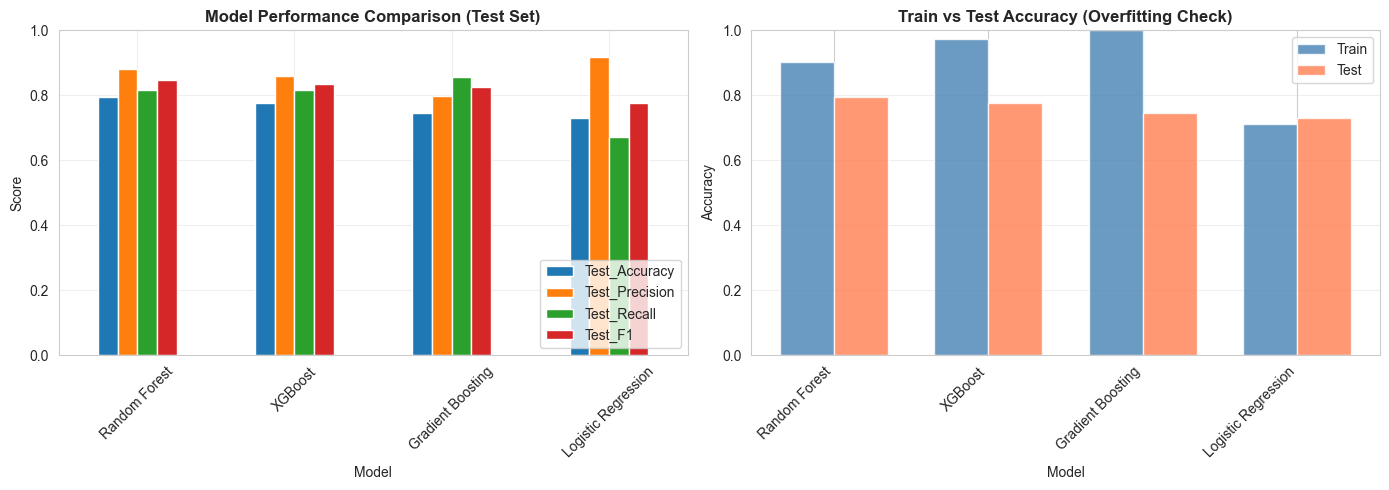


🏆 Best Model: Random Forest (F1-Score: 0.8472)


In [62]:
print("\n[8.3] Model Comparison")

# Create comparison DataFrame
results_df = pd.DataFrame(training_results)

# Sort by F1-Score (balanced metric for imbalanced data)
results_df = results_df.sort_values('Test_F1', ascending=False).reset_index(drop=True)

print("\n--- Model Performance Comparison ---")
display(results_df)

# Save comparison
Path('reports').mkdir(exist_ok=True)
results_df.to_csv('reports/model_comparison.csv', index=False)
print("\n✓ Comparison saved to: reports/model_comparison.csv")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Test Metrics Comparison
metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
results_df[['Model'] + metrics_to_plot].set_index('Model').plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Model Performance Comparison (Test Set)', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Train vs Test Accuracy (Overfitting check)
x_pos = np.arange(len(results_df))
width = 0.35
axes[1].bar(x_pos - width/2, results_df['Train_Accuracy'], width, 
           label='Train', alpha=0.8, color='steelblue')
axes[1].bar(x_pos + width/2, results_df['Test_Accuracy'], width, 
           label='Test', alpha=0.8, color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train vs Test Accuracy (Overfitting Check)', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(0, 1)

plt.tight_layout()
Path('reports/figures').mkdir(parents=True, exist_ok=True)
plt.savefig('reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['Test_F1']
print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")

## 8.4) Detailed Evaluation of Best Model


[8.4] Detailed Evaluation of Best Model

Best Model: Random Forest

--- Classification Report ---
                 precision    recall  f1-score   support

 Bad Credit (0)       0.63      0.75      0.68        51
Good Credit (1)       0.88      0.82      0.85       119

       accuracy                           0.79       170
      macro avg       0.76      0.78      0.77       170
   weighted avg       0.81      0.79      0.80       170


--- Confusion Matrix ---
True Negatives:  38
False Positives: 13
False Negatives: 22
True Positives:  97

--- Business Interpretation ---
Correctly rejected bad credits: 38 (74.5% of bad credits)
Incorrectly approved bad credits (COST): 13
Incorrectly rejected good credits (OPPORTUNITY LOSS): 22
Correctly approved good credits: 97 (81.5% of good credits)


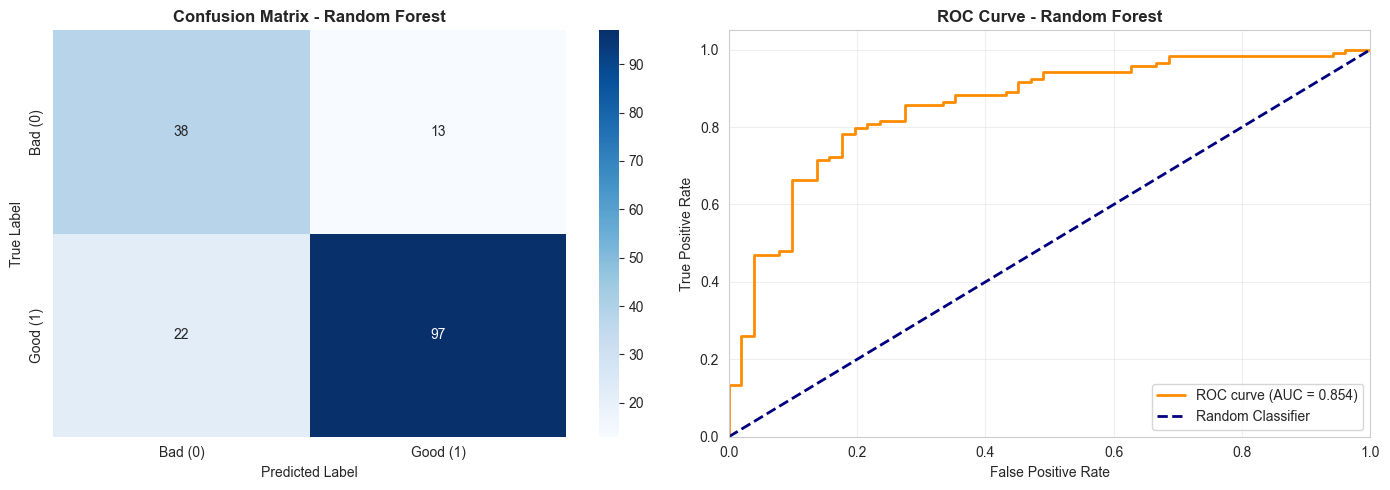

In [63]:
print("\n[8.4] Detailed Evaluation of Best Model")
print(f"\nBest Model: {best_model_name}")

best_model_info = fitted_models[best_model_name]
best_model = best_model_info['model']
y_pred_best = best_model_info['y_pred']
y_score_best = best_model_info['y_score']

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_best, 
                           target_names=['Bad Credit (0)', 'Good Credit (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\n--- Confusion Matrix ---")
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Business interpretation
tn, fp, fn, tp = cm.ravel()
print("\n--- Business Interpretation ---")
print(f"Correctly rejected bad credits: {tn} ({100*tn/(tn+fp):.1f}% of bad credits)")
print(f"Incorrectly approved bad credits (COST): {fp}")
print(f"Incorrectly rejected good credits (OPPORTUNITY LOSS): {fn}")
print(f"Correctly approved good credits: {tp} ({100*tp/(tp+fn):.1f}% of good credits)")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['Bad (0)', 'Good (1)'],
           yticklabels=['Bad (0)', 'Good (1)'])
axes[0].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
if y_score_best is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_score_best)
    roc_auc = roc_auc_score(y_test, y_score_best)
    
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {best_model_name}', fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'ROC Curve not available\n(model does not support probability)', 
                ha='center', va='center')
    axes[1].set_title('ROC Curve', fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/best_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

## 8.5) Feature Importance


[8.5] Feature Importance Analysis

✓ Random Forest supports feature importance

--- Top 10 Most Important Features ---
            Feature  Importance
   checking_account    0.156189
             amount    0.116125
   amount_per_month    0.095948
        debt_burden    0.065224
         age_at_end    0.063487
                age    0.056011
           duration    0.055664
     credit_history    0.051811
    savings_account    0.049523
employment_duration    0.047384


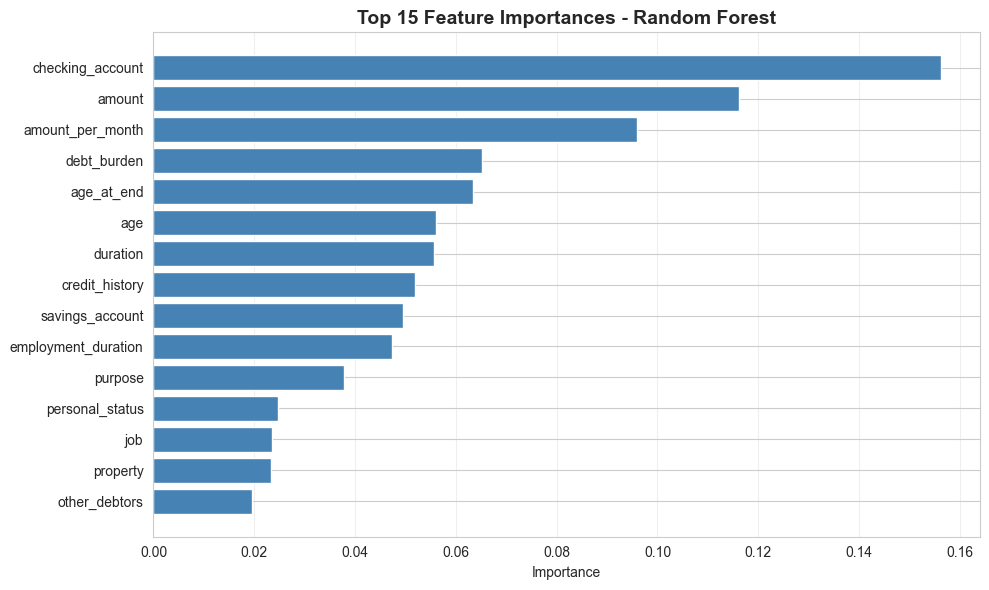


✓ Feature importance saved to: reports/feature_importance.csv


In [64]:
print("\n[8.5] Feature Importance Analysis")

# Check if model supports feature importance
if hasattr(best_model, 'feature_importances_'):
    print(f"\n✓ {best_model_name} supports feature importance")
    
    # Get feature importances
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\n--- Top 10 Most Important Features ---")
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    top_n = 15
    top_features = importance_df.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}', 
             fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save importance data
    importance_df.to_csv('reports/feature_importance.csv', index=False)
    print("\n✓ Feature importance saved to: reports/feature_importance.csv")

elif hasattr(best_model, 'coef_'):
    print(f"\n✓ {best_model_name} is a linear model (coefficients available)")
    
    # Get coefficients
    coefficients = best_model.coef_[0]
    feature_names = X_train.columns
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\n--- Top 10 Features by Absolute Coefficient ---")
    print(coef_df.head(10).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    top_n = 15
    top_features = coef_df.head(top_n)
    
    colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
    plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Feature Coefficients - {best_model_name}', 
             fontweight='bold', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('reports/figures/feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save coefficients
    coef_df.to_csv('reports/feature_coefficients.csv', index=False)
    print("\n✓ Feature coefficients saved to: reports/feature_coefficients.csv")
else:
    print(f"\n⚠ {best_model_name} does not support feature importance extraction")

## 8.6) Model Persistence

In [65]:
print("\n[8.6] Model Persistence")

# Create models directory
Path('models').mkdir(exist_ok=True)

# Save best model
model_path = 'models/best_model.pkl'
joblib.dump(best_model, model_path)
print(f"\n✓ Best model saved to: {model_path}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': X_train.shape[1],
    'metrics': {
        'test_accuracy': float(results_df.iloc[0]['Test_Accuracy']),
        'test_precision': float(results_df.iloc[0]['Test_Precision']),
        'test_recall': float(results_df.iloc[0]['Test_Recall']),
        'test_f1': float(results_df.iloc[0]['Test_F1']),
        'test_roc_auc': float(results_df.iloc[0]['Test_ROC_AUC']) if results_df.iloc[0]['Test_ROC_AUC'] is not None else None
    },
    'hyperparameters': best_model.get_params()
}

import json
metadata_path = 'models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

# Test loading
print("\n--- Testing Model Loading ---")
loaded_model = joblib.load(model_path)
test_predictions = loaded_model.predict(X_test.head(5))
print(f"✓ Model loaded successfully")
print(f"  Sample predictions (first 5): {test_predictions.tolist()}")



[8.6] Model Persistence

✓ Best model saved to: models/best_model.pkl
✓ Model metadata saved to: models/model_metadata.json

--- Testing Model Loading ---
✓ Model loaded successfully
  Sample predictions (first 5): [1, 1, 1, 0, 1]
